In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from wordcloud import WordCloud

%matplotlib inline

## Reading animelist.csv

In [392]:
import os
from config.paths_config import RAW_DIR

In [393]:
rating_df = pd.read_parquet(os.path.join("..", RAW_DIR, 'animelist.parquet'), columns=["user_id", "anime_id", "rating"])

In [394]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


## Data Processing

In [395]:
n_ratings = rating_df["user_id"].value_counts()
high_consumers = n_ratings[n_ratings >= 400].index
rating_df = rating_df.loc[rating_df["user_id"].isin(high_consumers)]

In [396]:
rating_df.head()

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0


In [397]:
max_rating = rating_df["rating"].max()
min_rating = rating_df["rating"].min()
avg_rating = rating_df["rating"].mean()
min_rating, avg_rating, max_rating

(np.int64(0), np.float64(4.122732695114736), np.int64(10))

- min-max scaling

In [398]:

rating_df["rating"] = (rating_df["rating"] - min_rating) / (max_rating - min_rating)

- check for duplicates

In [399]:
rating_df.duplicated().sum()

np.int64(0)

In [400]:
user_ids = rating_df["user_id"].unique().tolist()
anime_ids = rating_df["anime_id"].unique().tolist()

In [401]:
rating_df = rating_df.sample(frac=1, random_state=42).reset_index(drop=True)

user_id_encoding = {x: i for i, x in enumerate(user_ids)}
user_id_decoding = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user_id_encoding)

anime_id_encoding = {x: i for i, x in enumerate(anime_ids)}
anime_id_decoding = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime_id_encoding)

In [402]:
X = rating_df[["user", "anime"]].to_numpy()
y = rating_df["rating"]
X

array([[3405,  688],
       [4060, 1518],
       [1213, 4963],
       ...,
       [2881, 5028],
       [3569,  175],
       [2870, 1895]])

In [403]:
test_frac = 0.1
test_size = int(len(X) * test_frac)
X_train = [X[:-test_size, 0], X[:-test_size, 1]]
X_test = [X[-test_size:, 0], X[-test_size:, 1]]
y_train = y[:-test_size]
y_test = y[-test_size:]

test_size

324664

## Model Architecture

In [404]:
def recommender_net(n_users: int, n_animes: int,
                    user_embedding_size=8,
                    anime_embedding_size=16,
                    dropout: float | None = .2) -> Model:
    user = Input(name="user", shape=[1])
    user_embedding = Embedding(name="user_embedding",
                               embeddings_regularizer=l2(1e-6),
                               input_dim=n_users,
                               output_dim=user_embedding_size)(user)
    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(name="anime_embedding",
                                embeddings_regularizer=l2(1e-6),
                                input_dim=n_animes,
                                output_dim=anime_embedding_size)(anime)
    user_embedding = Dense(name="user_projection", units=32)(user_embedding)
    anime_embedding = Dense(name="anime_projection", units=32)(anime_embedding)
    user_embedding = Activation("relu")(user_embedding)
    anime_embedding = Activation("relu")(anime_embedding)
    x = Dot(name="dot_product", normalize=True, axes=2)(inputs=[user_embedding, anime_embedding])
    x = Flatten()(x)
    if dropout is not None:
        x = Dropout(dropout)(x)

    x = Dense(units=1)(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss="binary_crossentropy",
                  metrics=["mae", "mse"],
                  optimizer="Adam")
    return model


In [405]:
model = recommender_net(n_users=len(user_ids), n_animes=len(anime_ids))
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 8)      │     33,624 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 16)     │    274,384 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_projection     │ (None, 1, 32)     │        288 │ user_embedding[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_projection    │ (None, 1, 32)     │        544 │ anime_embedding[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 1, 32)     │          0 │ user_projection[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 1, 32)     │          0 │ anime_projection… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ activation_25[0]… │
│                     │                   │            │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 1)         │          0 │ dot_product[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 1)         │          0 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │          2 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_21[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 308,846 (1.18 MB)

 Trainable params: 308,844 (1.18 MB)

 Non-trainable params: 2 (8.00 B)

In [406]:
checkpoint_fp = os.path.join(".", "weights.weights.h5")
model_checkpoint = ModelCheckpoint(filepath=checkpoint_fp,
                                   save_weights_only=True,
                                   monitor="val_loss",
                                   mode="min",
                                   save_best_only=True)
early_stopping = EarlyStopping(patience=3,
                               monitor="val_loss",
                               mode="min",
                               restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',   # what metric to monitor
    factor=0.5,           # reduce LR by this factor
    patience=2,           # wait this many epochs with no improvement
    min_lr=1e-6,          # (optional) don't go below this LR
    verbose=1             # print when it happens
)

callbacks = [model_checkpoint, early_stopping, lr_schedule]

In [407]:
batch_size = 2048

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=14,
    verbose=True,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Epoch 1/14
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.6518 - mae: 0.3176 - mse: 0.1333 - val_loss: 0.5812 - val_mae: 0.2855 - val_mse: 0.1024 - learning_rate: 0.0010
Epoch 2/14
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.6068 - mae: 0.2927 - mse: 0.1141 - val_loss: 0.5782 - val_mae: 0.2821 - val_mse: 0.1010 - learning_rate: 0.0010
Epoch 3/14
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.6046 - mae: 0.2902 - mse: 0.1131 - val_loss: 0.5770 - val_mae: 0.2812 - val_mse: 0.1004 - learning_rate: 0.0010
Epoch 4/14
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.6030 - mae: 0.2885 - mse: 0.1122 - val_loss: 0.5768 - val_mae: 0.2822 - val_mse: 0.1003 - learning_rate: 0.0010
Epoch 5/14
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.6006 - mae: 0.2864 - mse: 0.1112 - val_loss: 0.5740 - val_mae: 0.2793 - val_mse: 0.0989 - learning_rate: 0.0010
Epoch 6/14
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.5982 - mae: 0.2838 - mse: 0.1099 - val_loss: 0.574

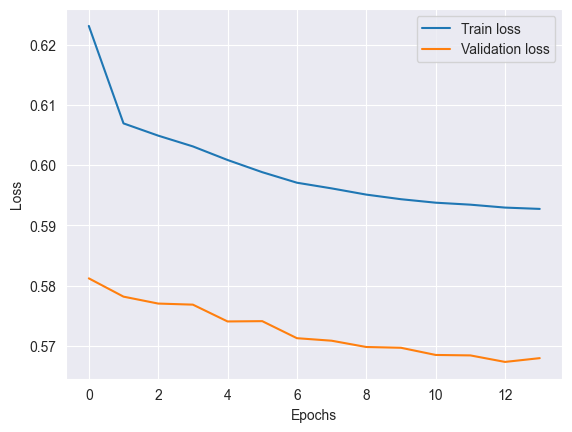

In [408]:
val_loss = history.history["val_loss"]
train_loss = history.history["loss"]

plt.plot(train_loss, label="Train loss")
plt.plot(val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Reading anime.parquet

In [409]:
df_path = os.path.join("..", RAW_DIR, "anime.parquet")
anime_df = pd.read_parquet(df_path,
                           columns=["MAL_ID", "Name", "Score",
                                    "Genres", "English name", "Type",
                                    "Premiered", "Members"])
anime_df.head()

,MAL_ID,Name,Score,Genres,English name,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,Spring 1998,1251960
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,Unknown,273145
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,TV,Spring 1998,558913
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,TV,Summer 2002,94683
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,TV,Fall 2004,13224


In [410]:
anime_df = anime_df.replace("Unknown", np.nan)

In [411]:
old_cols = anime_df.columns
sanitized_col_names_map = {col: col.lower().replace(" ", "_").replace("-", "_") for col in old_cols}

In [412]:
anime_df = (anime_df
            .rename(columns=sanitized_col_names_map)
            .rename(columns={"mal_id": "anime_id"}))
anime_df.head()

,anime_id,name,score,genres,english_name,type,premiered,members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,Spring 1998,1251960
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,NaN,273145
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,TV,Spring 1998,558913
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,TV,Summer 2002,94683
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,TV,Fall 2004,13224


In [413]:
def name_for_anime_id(df: pd.DataFrame, anime_id: int):
    this_entry = df[df.anime_id == anime_id]
    name = this_entry.english_name.iloc[0]
    if name == np.nan:
        name = this_entry.name.iloc[0]
    return name

In [414]:
name_for_anime_id(anime_df, 1)

'Cowboy Bebop'

In [415]:
anime_df.sort_values(by="score",
               inplace=True,
               ascending=False,
               na_position="last")
anime_df.head()

,anime_id,name,score,genres,english_name,type,premiered,members
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",Fullmetal Alchemist:Brotherhood,TV,Spring 2009,2248456
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",Attack on Titan Final Season,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,TV,Spring 2011,1771162
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",Attack on Titan Season 3 Part 2,TV,Spring 2019,1073626
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",Gintama Season 4,TV,Spring 2015,404121


In [416]:
def get_anime_frame(df, anime: int | str) -> pd.DataFrame:
    if isinstance(anime, int):
        anime = df[df.anime_id == anime]
    elif isinstance(anime, str):
        anime = df[df.english_name == anime]
    else:
        raise ValueError("anime must be an int or str")
    return anime

In [417]:
get_anime_frame(anime_df, 28977)

,anime_id,name,score,genres,english_name,type,premiered,members
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",Gintama Season 4,TV,Spring 2015,404121


In [418]:
get_anime_frame(anime_df, "Gintama Season 4")

,anime_id,name,score,genres,english_name,type,premiered,members
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",Gintama Season 4,TV,Spring 2015,404121


## Load anime_with_synopsis.parquet

In [419]:
df_path = os.path.join("..", RAW_DIR, "anime_with_synopsis.parquet")
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]
synopsis_df = pd.read_parquet(df_path, columns=cols)
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the stronge

In [420]:
old_cols = synopsis_df.columns
sanitized_col_names_map = {col: col.lower().replace(" ", "_").replace("-", "_") for col in old_cols}

In [421]:
synopsis_df = (synopsis_df
               .rename(columns=sanitized_col_names_map)
               .rename(columns={"sypnopsis": "synopsis", "mal_id": "anime_id"}))

In [422]:
def get_synopsis(df, anime: int | str) -> pd.DataFrame:
    if isinstance(anime, int):
        synopsis = df[df.anime_id == anime].synopsis.iloc[0]
    elif isinstance(anime, str):
        synopsis = df[df.name == anime].synopsis.iloc[0]
    else:
        raise ValueError("anime must be an int or str")
    return synopsis

In [423]:
get_synopsis(synopsis_df, 6)

'Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he\'s a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title "The Humanoid Typhoon." He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash\'s agonizing past will be unraveled and his morality and principles pushed to the breakin

In [424]:
get_synopsis(synopsis_df, "Trigun")

'Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he\'s a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title "The Humanoid Typhoon." He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash\'s agonizing past will be unraveled and his morality and principles pushed to the breakin

## Content-based recommendation

In [425]:
# todo